# **LIBRARIES**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


What we would like to do is to load data in main memory to speed up processing (HOPEFULLY) 


In [ ]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '../input/correctedbal',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    subset='training',
    validation_split=0.2,
    seed=seed,
)

data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.5),
    tfkl.RandomZoom( height_factor=(-0.3, 0.3),width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=13, fill_value=0.0)
])

dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation(x), y)) #selective augmentation 

Found 414 files belonging to 8 classes.
Using 332 files for training.


In [ ]:
# new augmentation layer 
data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.5),
    tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=17),
    tf.keras.layers.RandomTranslation( height_factor = (-0.3,0.3),width_factor = (-0.3,0.3), fill_mode='reflect', interpolation='bilinear',seed=19)
])


In [ ]:
datapath = '../input/annhw1/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2, #splitting in memory 
    subset="training",
)

#-------------------------------------------------------
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)
#-------------------------------------------------------

training_set = training_set.concatenate(dataAugmImbal) #selective augmentation 
training_set = training_set.concatenate( training_set.map(lambda x , y : (data_augmentation(x), y)) ) #total augmentation 

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
{0: 2.300324675324675, 1: 0.8315727699530516, 2: 0.8598300970873787, 3: 0.8619221411192214, 4: 0.8414489311163895, 5: 2.001412429378531, 6: 0.8414489311163895, 7: 0.8598300970873787}
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


***RESCALING***

In [ ]:
rescaling = tfkl.Rescaling(1./255)
training_set = training_set.map(lambda x,y: (rescaling(x),y))
validation_set = validation_set.map(lambda x,y: (rescaling(x),y))

***NORMALIZATION***

In [ ]:
normalization = tfkl.Normalization(axis=-1)
normalization.adapt(training_set.map(lambda x,y: x)) # trained on augm test set only
print(normalization.get_weights()) 

training_set = training_set.map(lambda x,y: (normalization(x),y))
validation_set = validation_set.map(lambda x,y: (normalization(x),y))


[array([0.3438392 , 0.37360623, 0.34854415], dtype=float32), array([0.03530984, 0.0360656 , 0.03406299], dtype=float32), 58355712]


# **Training**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [ ]:
def build_model(input_shape):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Resizing(128,128, interpolation="bicubic", name='resizing')(input_layer)
    x = tfkl.Conv2D(
        filters=8,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(x)
    x = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+1)
    )(x)
    
    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+2)
    )(x)
    
    x = tfkl.Conv2D(
        filters=48,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+2)
    )(x)
    
    x = tfkl.MaxPooling2D()(x)
    
    x = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+3)
    )(x)
    
    x = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+4)
    )(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x) 
        
    d = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed-6), kernel_regularizer = tf.keras.regularizers.L2(l2=0.001),  activation='relu')(x)
    
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed-9), name='output_layer')(d)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

    return model

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []
  
  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) #tuning point
  callbacks.append(es_callback)
  return callbacks

In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 48)        13872 

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel_TESTING')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
    workers=2
    ,class_weight = weights 
).history

Epoch 1/200
200/200 [==============================] - 23s 48ms/step - loss: 2.2963 - accuracy: 0.1963 - val_loss: 1.9262 - val_accuracy: 0.2782
Epoch 2/200
200/200 [==============================] - 7s 33ms/step - loss: 2.0941 - accuracy: 0.2566 - val_loss: 1.8761 - val_accuracy: 0.2571
Epoch 3/200
200/200 [==============================] - 7s 33ms/step - loss: 1.9954 - accuracy: 0.2887 - val_loss: 1.6572 - val_accuracy: 0.3955
Epoch 4/200
200/200 [==============================] - 7s 35ms/step - loss: 1.8999 - accuracy: 0.3201 - val_loss: 1.7214 - val_accuracy: 0.3842
Epoch 5/200
200/200 [==============================] - 7s 36ms/step - loss: 1.8475 - accuracy: 0.3508 - val_loss: 1.7576 - val_accuracy: 0.3588
Epoch 6/200
200/200 [==============================] - 7s 33ms/step - loss: 1.7843 - accuracy: 0.3681 - val_loss: 1.5465 - val_accuracy: 0.4124
Epoch 7/200
200/200 [==============================] - 7s 33ms/step - loss: 1.7519 - accuracy: 0.3852 - val_loss: 1.4256 - val_accuracy

In [ ]:
final_time = datetime.now()
print("Training took %s" % (final_time - initial_time))

Training took 0:16:49.007924


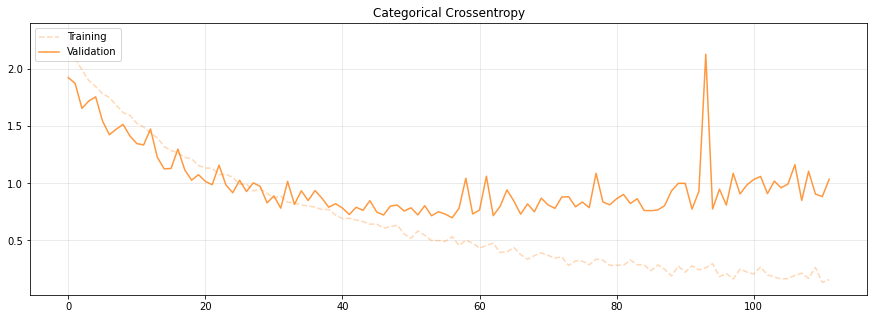

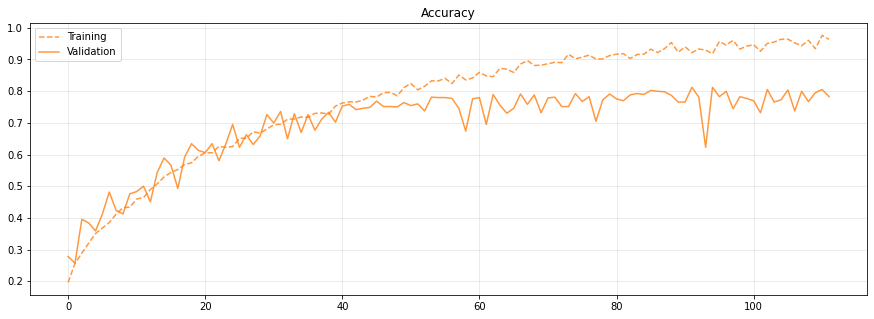

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save("models/myModel")

23/23 [==============================] - 0s 16ms/step - loss: 0.7749 - accuracy: 0.8121
{'loss': 0.7748787999153137, 'accuracy': 0.8121469020843506}
Accuracy: 0.8121
Precision: 0.7957
Recall: 0.8024
F1: 0.7981
F1 (per class):
[0.60869565 0.78431373 0.89423077 0.76923077 0.87557604 0.87912088
 0.88288288 0.69035533]
WORST CLASS: Species: 1


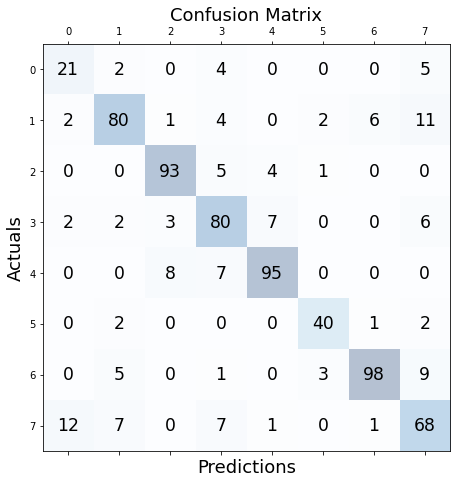

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()